## For download the dataset, please visit:

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [4]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)
print(tf.__version__)

2.9.1


In [5]:
height, width = 128, 128
batch_size=64

In [116]:
data_dir = 'brain_tumor_dataset'

datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.2,
        )
train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode='binary',
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
        )
val_ds = datagen.flow_from_directory(
          data_dir,
          subset="validation",
          #seed=123,
          class_mode='binary',
          target_size=(height, width),
          batch_size=batch_size,
        classes={'no': 0., 'yes': 1.}
        )

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


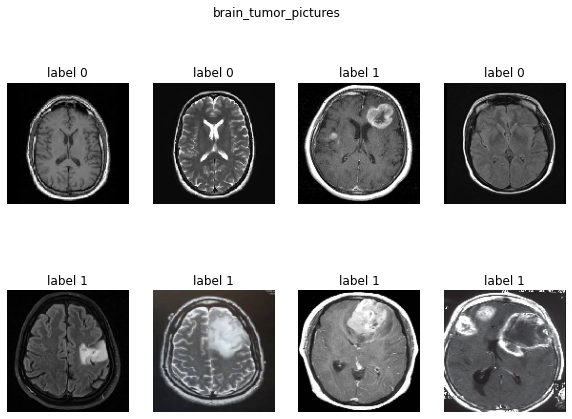

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

In [20]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
#model_vgg19.add(tf.keras.layers.GlobalAveragePooling2D())
model_vgg19.add(tf.keras.layers.Flatten())
model_vgg19.add(tf.keras.layers.Dropout(0.25))
model_vgg19.add(tf.keras.layers.Dense(64, activation='relu'))
#model_vgg19.add(tf.keras.layers.Dense(32, activation='relu'))
model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,548,801
Trainable params: 524,417
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list

In [22]:
model_vgg19.evaluate(val_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.1857 - acc: 0.9400


[0.18566712737083435, 0.9399999976158142]

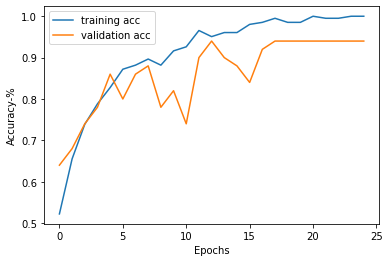

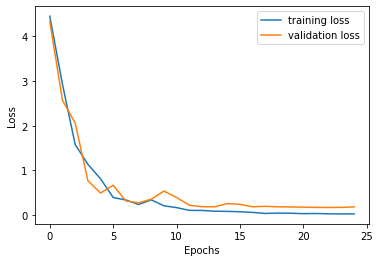

In [23]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [24]:
ypred = model_vgg19.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print(confusion_matrix(ytest, ypred))
print('VGG19_CNN:\n',classification_report(ypred,ytest))

2/2 [==============================] - 1s 479ms/step
[[19  0]
 [ 3 28]]
VGG19_CNN:
               precision    recall  f1-score   support

           0       1.00      0.86      0.93        22
           1       0.90      1.00      0.95        28

    accuracy                           0.94        50
   macro avg       0.95      0.93      0.94        50
weighted avg       0.95      0.94      0.94        50



In [61]:
# inception v3
tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
#model_inceptionv3.add(tf.keras.layers.GlobalAveragePooling2D())
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dropout(0.25))
#model_inceptionv3.add(tf.keras.layers.Dense(8, activation='relu'))
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.01),
                    metrics=['acc']
)
model_inceptionv3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8193      
                                                                 
Total params: 21,810,977
Trainable params: 8,193
Non-trainable params: 21,802,784
_________________________________________________________________


In [62]:
# train inception v3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 2.9548 - acc: 0.6502
Epoch 1: acc improved from -inf to 0.65025, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 6s 874ms/step - loss: 2.9548 - acc: 0.6502 - val_loss: 2.5018 - val_acc: 0.7600
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.8439 - acc: 0.8227
Epoch 2: acc improved from 0.65025 to 0.82266, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 2s 572ms/step - loss: 1.8439 - acc: 0.8227 - val_loss: 2.8613 - val_acc: 0.7400
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.3427 - acc: 0.8768
Epoch 3: acc improved from 0.82266 to 0.87685, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 2s 495ms/step - loss: 1.3427 - acc: 0.8768 - val_loss: 4.1778 - val_acc: 0.7200
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.6106 - acc: 0.8128
Epoch 4: acc did not improv

In [63]:
model_inceptionv3.evaluate(val_ds)

1/1 [==============================] - 0s 378ms/step - loss: 1.9215 - acc: 0.8400


[1.9214630126953125, 0.8399999737739563]

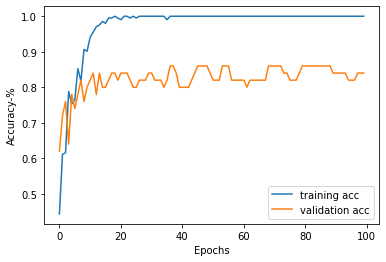

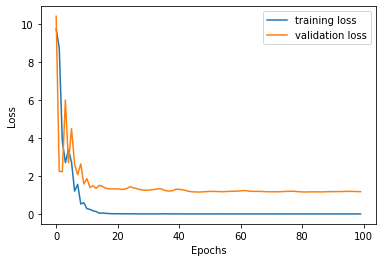

In [49]:
plot_learning_curve(history)

In [64]:
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

2/2 [==============================] - 1s 114ms/step
Confusion_Matrix:
 [[12  7]
 [ 1 30]]

Classification_report:
               precision    recall  f1-score   support

           0       0.63      0.92      0.75        13
           1       0.97      0.81      0.88        37

    accuracy                           0.84        50
   macro avg       0.80      0.87      0.82        50
weighted avg       0.88      0.84      0.85        50

